### PS6
Havish Potharaju, Jack Passyn, Maggie Sun 

In [1]:
import arch
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import math
import yfinance as yf
import pandas as pd
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

In [2]:
class Vol_analysis:
    def __init__(self, rets_data):
        self.ret_data = rets_data
        self.vol_data = rets_data.resample('ME').std()*np.sqrt(30)
        self.monthly_rets = rets_data.resample('ME').sum()
    
    def fit_AR(self, lag):
        model = sm.tsa.AutoReg(self.vol_data.to_numpy(), lags = lag)
        return model.fit()

    def fit_GARCH(self,p,q,scaling=100,isGJ = False):
        if isGJ:
            model = arch.arch_model(scaling*self.monthly_rets.to_numpy(), vol='GARCH', p=p,o=1,q=q )
        else:
            model = arch.arch_model(scaling*self.monthly_rets.to_numpy(), vol='GARCH', p=p,q=q )
        return model.fit(disp = 'off')

    def best_GARCH(self,scaling=100,isGJ = False):
        p = np.linspace(1,5,5)
        q = np.linspace(1,5,5)
        aic = np.zeros([len(p),len(q)])
        for i in p:
            for j in q:
                GARCH_fit = self.fit_GARCH(int(i),int(j),scaling=scaling,isGJ=isGJ)
                aic[int(i-1)][int(j-1)] = GARCH_fit.aic
        max_loc = np.unravel_index(np.argmin(aic),aic.shape)
        return max_loc

def acf_analysis(data):
    data = data - np.mean(data)
    AutoCorrel = np.correlate(data,data,mode = "full")/(len(data)*np.var(data)) ### Standardize to have correls wrt 1
    return AutoCorrel[len(AutoCorrel) // 2 :]

def acf_plot(series):
    acf = acf_analysis(series)
    plt.figure(figsize = (10,6))
    plt.title("Autocorrelation Function")
    plt.stem(np.arange(1,6,1), acf[1:6])
    plt.grid()
    plt.xlabel("Lags")
    plt.ylabel("ACF")
    plt.show()

def OLS_fit(X,y):
    X = sm.add_constant(X)
    ols_model = sm.OLS(y, X).fit()
    return ols_model,ols_model.predict(X)

def forecast_stats(forecast,GT):
    RMSE = root_mean_squared_error(forecast,GT)
    MAE = mean_absolute_error(forecast, GT)
    return RMSE,MAE

In [3]:
def data_analysis(data,key):
    print(f"Analysis for the dataset of {key}")
    data['Daily_Return'] = data[key].pct_change().apply(lambda x: np.log(1 + x))
    data = data.dropna()
    Monthly_returns = data['Daily_Return'].resample('ME').sum()
    Yearly_returns = data['Daily_Return'].resample('YE').sum()
    print("Acf of daily returns: \n")
    acf_plot(data["Daily_Return"].to_numpy())
    print("Acf of Monthly returns: \n")
    acf_plot(Monthly_returns.to_numpy())
    print("Acf of Yearly returns: \n")
    acf_plot(Yearly_returns.to_numpy())
    
    daily_ann_vol = np.sqrt(252)*data["Daily_Return"].std()
    Monthly_ann_vol = np.sqrt(12)*Monthly_returns.std()
    Yearly_ann_vol = Yearly_returns.std()
    print(f"Daily: {daily_ann_vol}, Monthly: {Monthly_ann_vol}, Yearly:{Yearly_ann_vol}")

    monthly_vols = np.abs(Monthly_returns - Monthly_returns.mean())
    vol_monthly = np.sqrt(30)*data["Daily_Return"].resample('ME').std() ### Annualize
    plt.figure(figsize=(20,6))
    plt.plot(monthly_vols,label="Volatility of monthly returns")
    plt.plot(vol_monthly, label= "Monthly realized volatility")
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("Vol")
    plt.legend()
    plt.show()
    monthly_mu, monthly_sig = monthly_vols.mean(),monthly_vols.var()
    vol_mu, vol_sig = vol_monthly.mean(),vol_monthly.var()
    correl = np.correlate(monthly_vols,vol_monthly) - 1
    print(f"Correlation between volatility of monthly returns and realized monthly vol from daily returns {correl}\n")
    print(f"mean and variance of the volatility of monthly returns {monthly_mu}, {monthly_sig}\n")
    print(f"mean and variance of the monthly vol based on daily returns {vol_mu}, {vol_sig}\n")

    print("Fitting an AR1 Model")
    Vol_Obj = Vol_analysis(data["Daily_Return"])
    AR_model = Vol_Obj.fit_AR(1)
    print(AR_model.summary())
    AR_forecasts = AR_model.predict(start=0,end=len(vol_monthly)-1)
    MSE = np.mean((AR_forecasts[1:] - vol_monthly.to_numpy()[1:])**2)
    AR_RMSE,AR_MAE = forecast_stats(AR_forecasts[1:],vol_monthly.to_numpy()[1:])
    print(f"MSE of AR(1) forecasts is given as {MSE}")
    plt.figure(figsize=(20,6))
    plt.plot(vol_monthly.to_numpy(), label= "Monthly realized volatility")
    plt.plot(AR_forecasts, label= "Month ahead volatility forecasts")
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("Vol")
    plt.legend()
    plt.show()
    
    print("Fitting an GARCH(1,1) Model\n")
    GARCH_model = Vol_Obj.fit_GARCH(1,1,scaling = 100)
    GARCH_cond_vols = GARCH_model.conditional_volatility/100
    print(GARCH_model.summary())
    OLS_GARCH,GARCH_preds = OLS_fit(GARCH_cond_vols, vol_monthly.to_numpy().reshape(-1,1))
    GARCH_RMSE,GARCH_MAE = forecast_stats(GARCH_cond_vols[1:],vol_monthly.to_numpy()[1:])
    plt.figure(figsize=(10, 6))
    plt.scatter(GARCH_cond_vols, vol_monthly.to_numpy(), label='Data Points')
    plt.plot(GARCH_cond_vols, GARCH_preds, color='red', label='Regression')
    plt.title('Regression of Realized Volatility on Conditional Volatility')
    plt.xlabel('Conditional Volatility (GARCH(1,1))')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.grid()
    plt.show()
    
    print("Fitting an GJR-GARCH(1,1) Model\n")
    GJ_GARCH_model = Vol_Obj.fit_GARCH(1,1,scaling = 100,isGJ=True)
    print(GJ_GARCH_model.summary())
    GJ_GARCH_cond_vols = GJ_GARCH_model.conditional_volatility/100
    OLS_GJ_GARCH, GJ_GARCH_preds = OLS_fit(GJ_GARCH_cond_vols, vol_monthly)
    GARCH_GJ_RMSE,GARCH_GJ_MAE = forecast_stats(GJ_GARCH_cond_vols[1:],vol_monthly.to_numpy()[1:])
    plt.figure(figsize=(10, 6))
    plt.scatter(GJ_GARCH_cond_vols, vol_monthly, label='Data Points')
    plt.plot(GJ_GARCH_cond_vols, GJ_GARCH_preds, color='red', label='Regression')
    plt.title('Regression of Realized Volatility on Conditional Volatility')
    plt.xlabel('Conditional Volatility (GJR-GARCH(1,1))')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"RMSE of AR = {AR_RMSE}, GARCH = {GARCH_RMSE}, GJR_GARCH = {GARCH_GJ_RMSE},\n")
    print(f"MAE of AR = {AR_MAE}, GARCH = {GARCH_MAE}, GJR_GARCH = {GARCH_GJ_MAE},\n")
    
    best_p,best_q = Vol_Obj.best_GARCH(scaling=100)
    best_p_GJ,best_q_GJ = Vol_Obj.best_GARCH(scaling=100,isGJ=True)
    print(f"Best p,q for a GARCH model is given by {best_p+1},{best_q+1}")
    print(f"Best p,q for a GJ_GARCH model is given by {best_p_GJ+1},{best_q_GJ+1}")
    

Analysis for the dataset of SP500_Close
Acf of daily returns: 



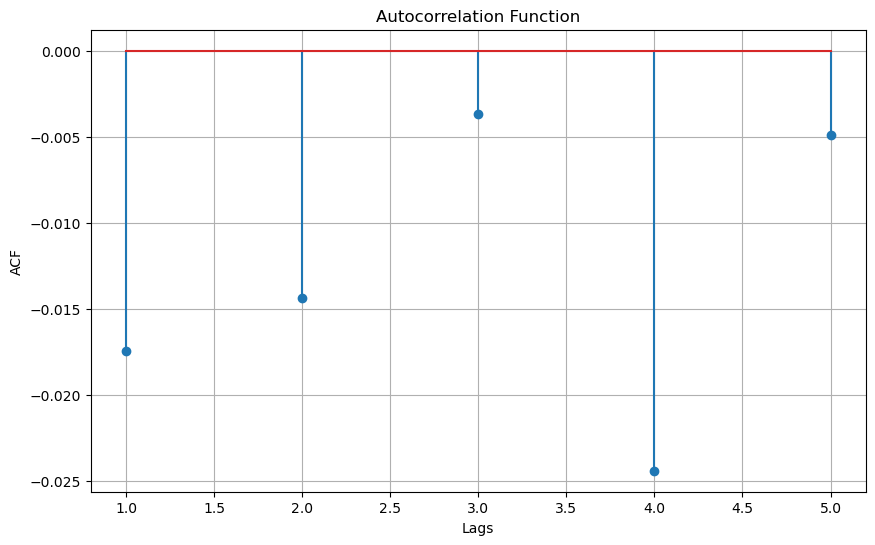

Acf of Monthly returns: 



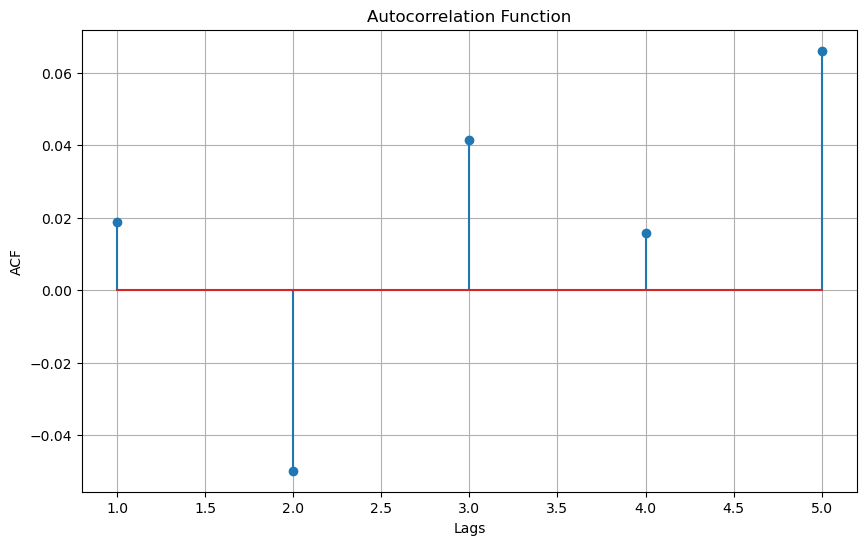

Acf of Yearly returns: 



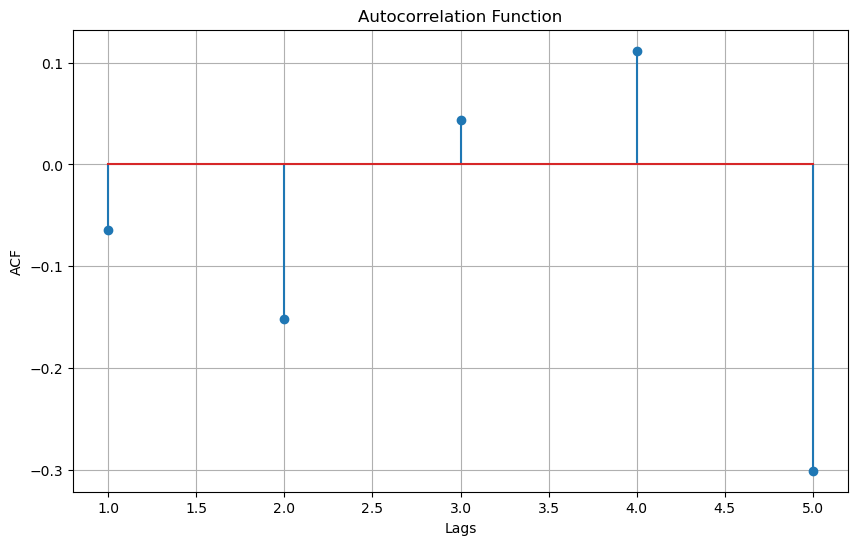

Daily: 0.17260199322398778, Monthly: 0.15478728436180667, Yearly:0.16628782598204842


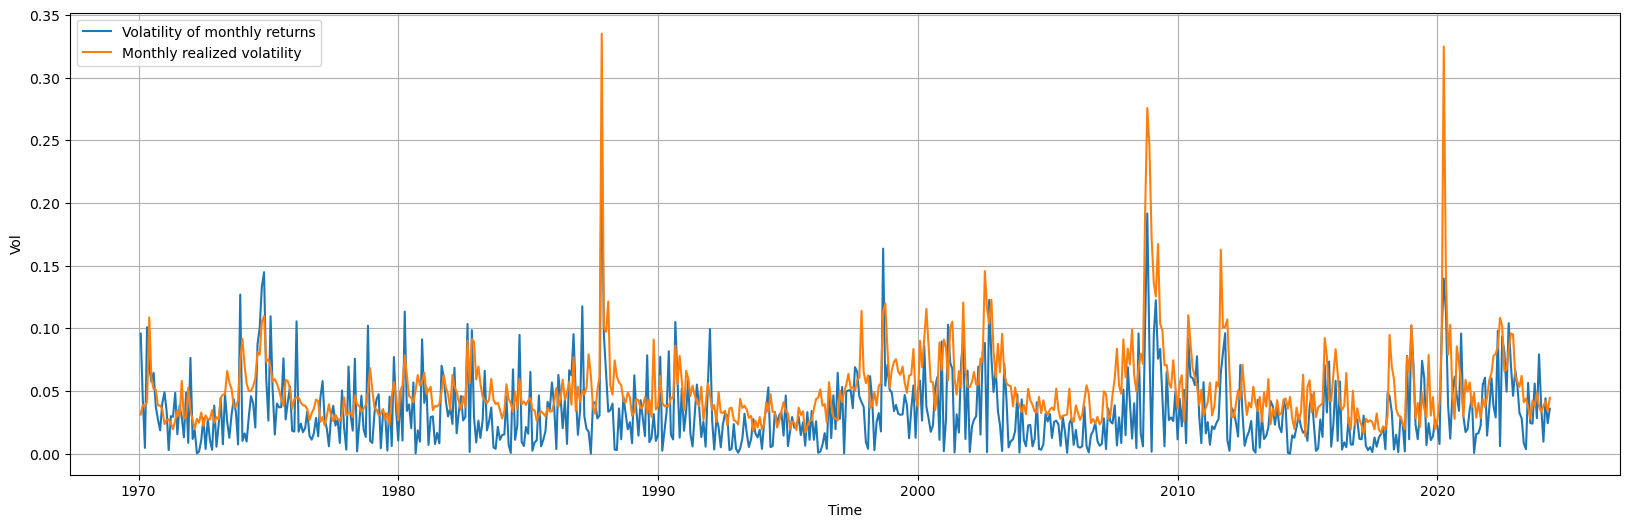

Correlation between volatility of monthly returns and realized monthly vol from daily returns [0.44201527]

mean and variance of the volatility of monthly returns 0.03359935882519407, 0.0008659409091811874

mean and variance of the monthly vol based on daily returns 0.0511016935290993, 0.0009518961628415989

Fitting an AR1 Model
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  652
Model:                     AutoReg(1)   Log Likelihood                1489.376
Method:               Conditional MLE   S.D. of innovations              0.025
Date:                Mon, 29 Apr 2024   AIC                          -2972.751
Time:                        14:54:20   BIC                          -2959.316
Sample:                             1   HQIC                         -2967.540
                                  652                                         
                 coef    std err     

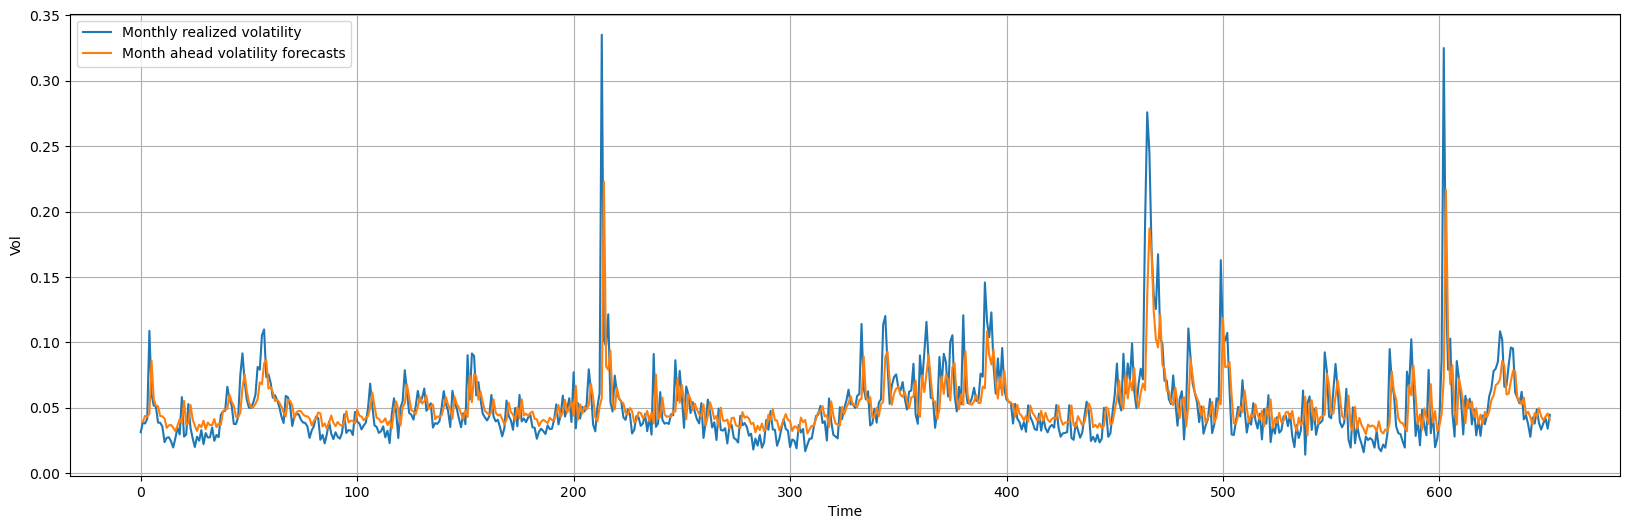

Fitting an GARCH(1,1) Model

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1874.85
Distribution:                  Normal   AIC:                           3757.70
Method:            Maximum Likelihood   BIC:                           3775.62
                                        No. Observations:                  652
Date:                Mon, Apr 29 2024   Df Residuals:                      651
Time:                        14:54:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6682      0.168      3.9

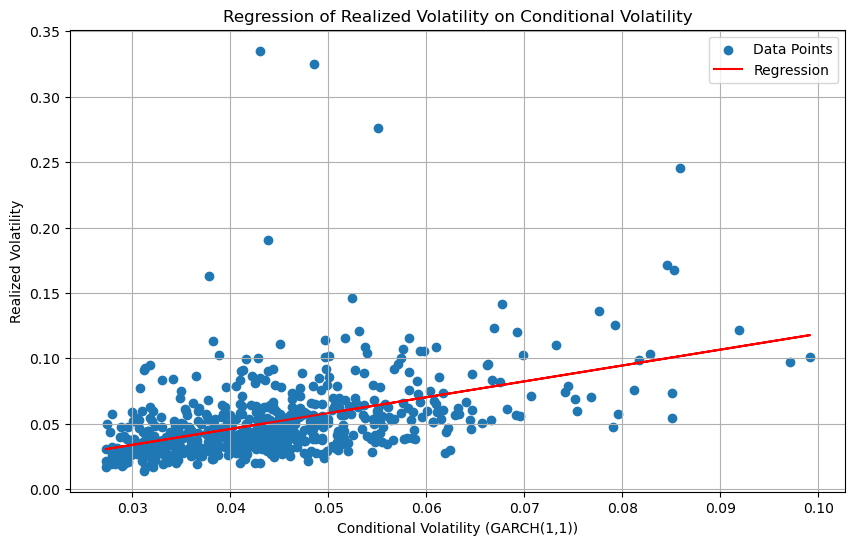

Fitting an GJR-GARCH(1,1) Model

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1867.55
Distribution:                  Normal   AIC:                           3745.10
Method:            Maximum Likelihood   BIC:                           3767.50
                                        No. Observations:                  652
Date:                Mon, Apr 29 2024   Df Residuals:                      651
Time:                        14:54:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6340      0.159     

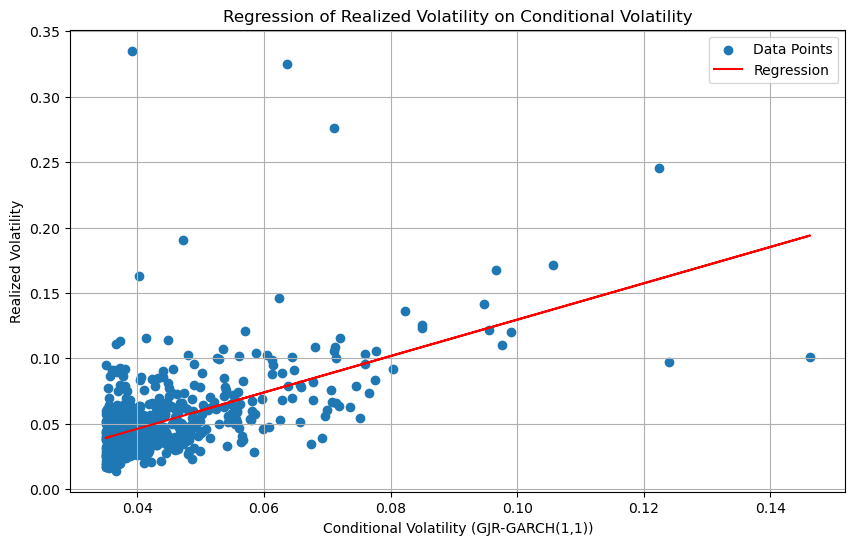

RMSE of AR = 0.02455681257092423, GARCH = 0.02830616150713624, GJR_GARCH = 0.027153413970369158,

MAE of AR = 0.01408470132132518, GARCH = 0.015134274730624215, GJR_GARCH = 0.015201652697089963,

Best p,q for a GARCH model is given by 3,3
Best p,q for a GJ_GARCH model is given by 3,3


In [4]:
start_date = "1970-01-01"
today = pd.Timestamp.today().strftime('%Y-%m-%d')

sp500_data = yf.download('^GSPC', start=start_date, end=today, progress=False)
ge_data = yf.download('GE', start=start_date, end=today, progress=False)

data = pd.DataFrame({'SP500_Close': sp500_data['Adj Close'], 'GE_Close': ge_data['Adj Close']})
data = data.dropna()
data_analysis(data,"SP500_Close")

Analysis for the dataset of GE_Close
Acf of daily returns: 



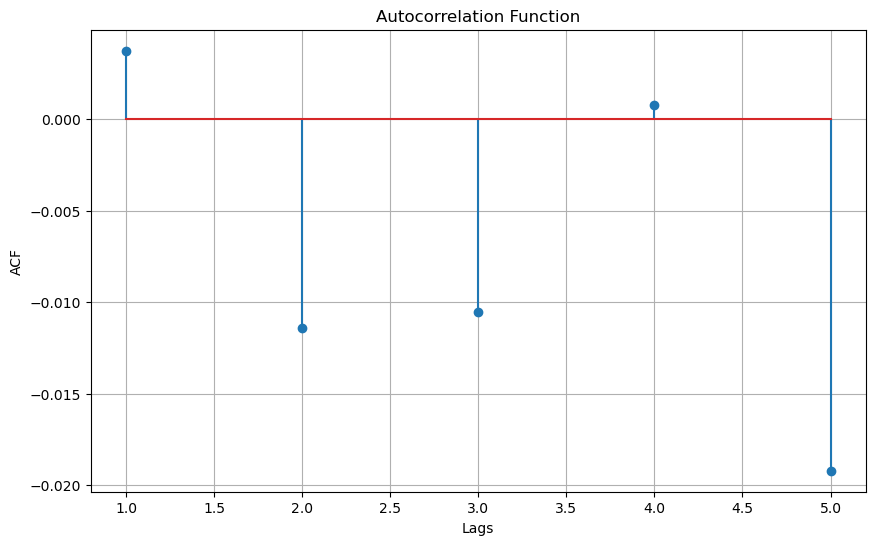

Acf of Monthly returns: 



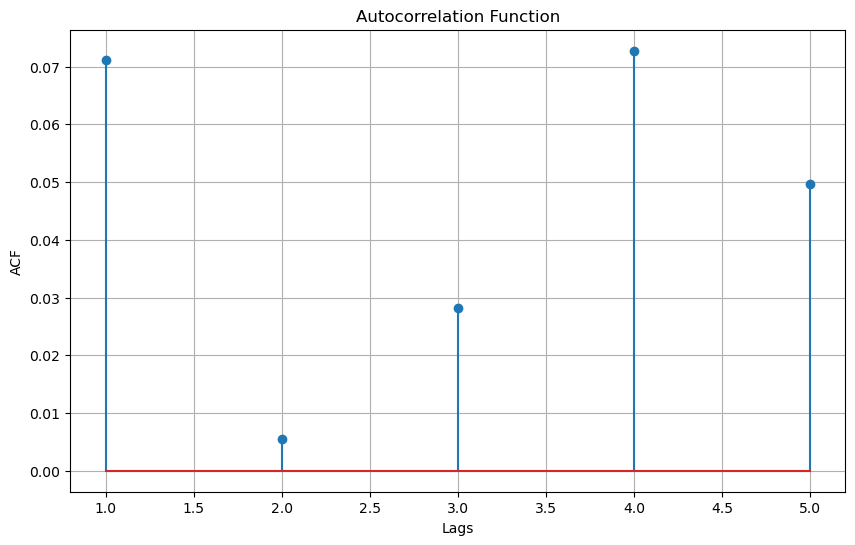

Acf of Yearly returns: 



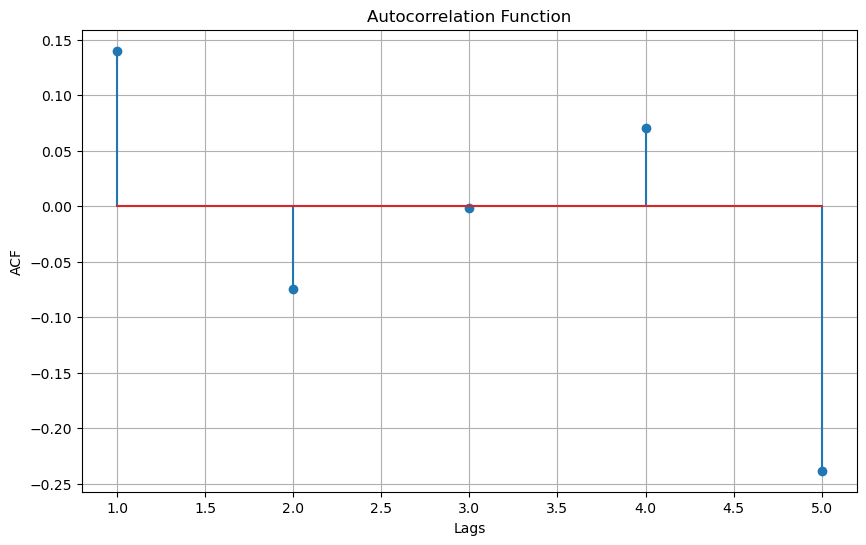

Daily: 0.28400426899635894, Monthly: 0.26478305344456465, Yearly:0.30104255492745374


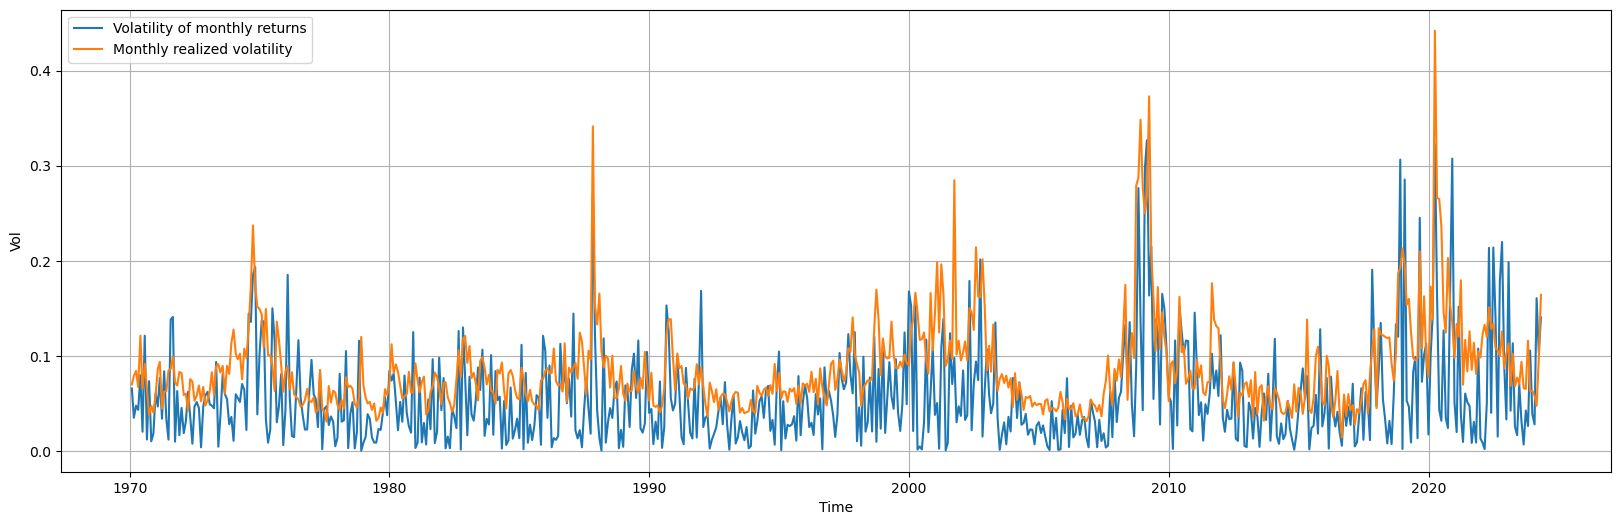

Correlation between volatility of monthly returns and realized monthly vol from daily returns [2.99932547]

mean and variance of the volatility of monthly returns 0.05603274728655943, 0.002698013840916027

mean and variance of the monthly vol based on daily returns 0.08606765718194749, 0.0022657029432863476

Fitting an AR1 Model
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  652
Model:                     AutoReg(1)   Log Likelihood                1275.209
Method:               Conditional MLE   S.D. of innovations              0.034
Date:                Mon, 29 Apr 2024   AIC                          -2544.417
Time:                        14:54:24   BIC                          -2530.982
Sample:                             1   HQIC                         -2539.206
                                  652                                         
                 coef    std err     

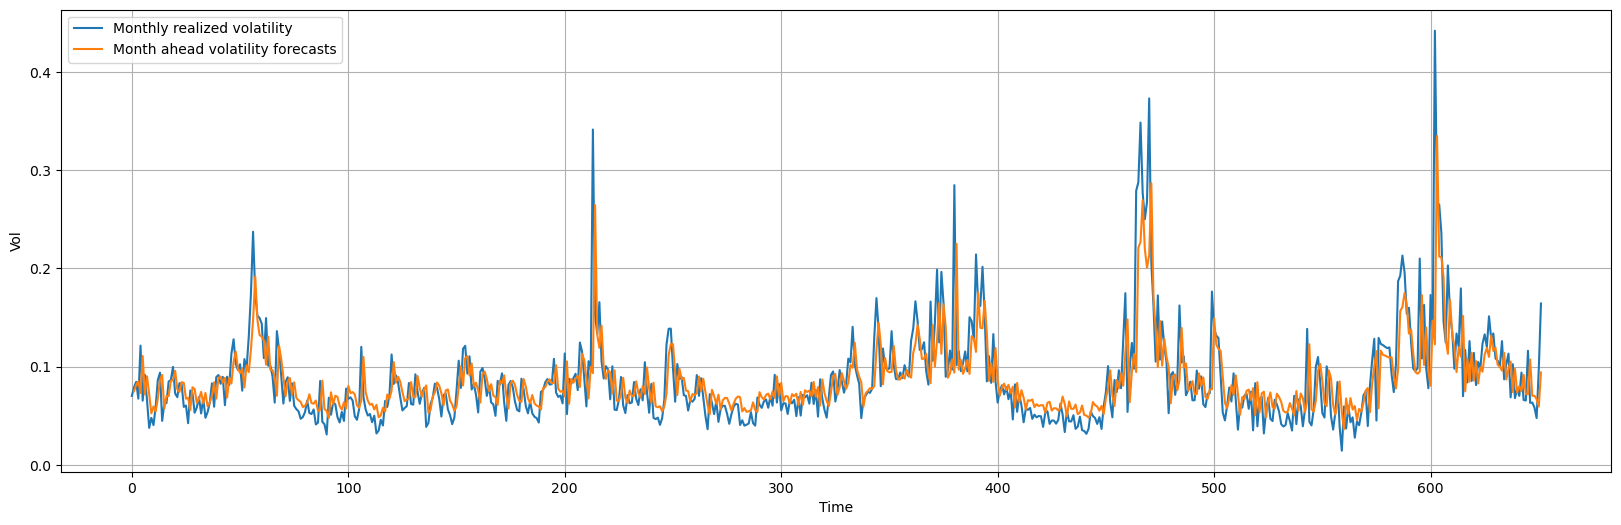

Fitting an GARCH(1,1) Model

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2193.87
Distribution:                  Normal   AIC:                           4395.74
Method:            Maximum Likelihood   BIC:                           4413.66
                                        No. Observations:                  652
Date:                Mon, Apr 29 2024   Df Residuals:                      651
Time:                        14:54:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.1241      0.257      4.3

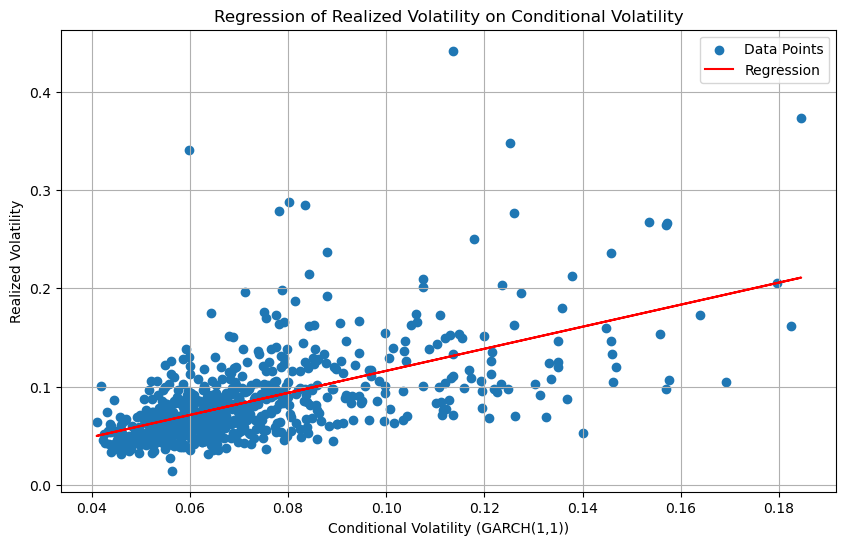

Fitting an GJR-GARCH(1,1) Model

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2187.20
Distribution:                  Normal   AIC:                           4384.40
Method:            Maximum Likelihood   BIC:                           4406.80
                                        No. Observations:                  652
Date:                Mon, Apr 29 2024   Df Residuals:                      651
Time:                        14:54:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.9084      0.261     

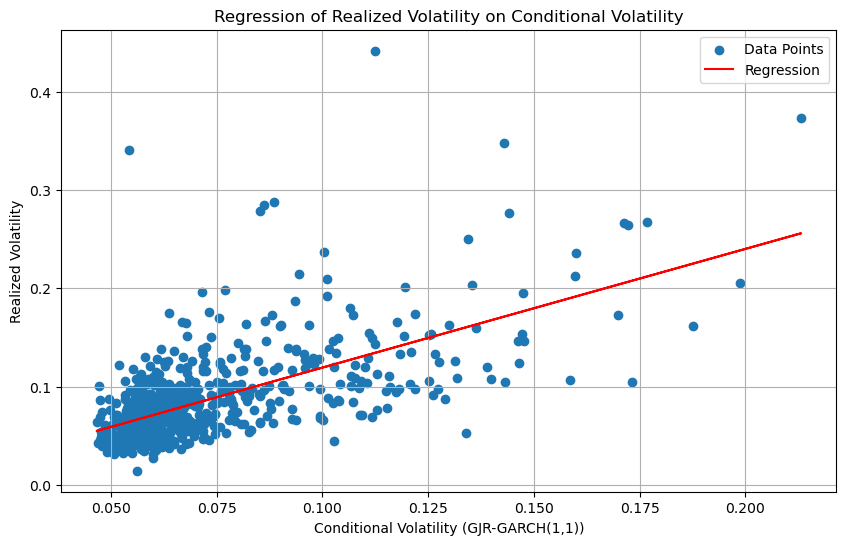

RMSE of AR = 0.03412297330945497, GARCH = 0.0407708198120595, GJR_GARCH = 0.039478956119573,

MAE of AR = 0.021813927085761495, GARCH = 0.024987373128515452, GJR_GARCH = 0.024402379114472666,

Best p,q for a GARCH model is given by 2,2
Best p,q for a GJ_GARCH model is given by 3,4


In [5]:
data_analysis(data,"GE_Close")

### Key Observations

- Firstly, in the sample annualized volatilities we can see that over different horizons, the values have slight variation. This can be attributed to the fact that there might be very short-term properties of data which would be lost in compounding and hence the slight differences in the values
- The acf plot shows a certain level of irregular pattern in terms of lag vs the amount of autocorrelation for all the $5$ lags
- The $AR(1)$ process fit seems to show a decent weight on first lag with the value being quite far away from a unit root implying this fit is indeed stationary
- We can see that the $AR(1)$ process has relatively low RMSE for both SPX and GE. Also an interesting point to note is that the log likelihood is positive with AIC/BIC being negative. Given the persistence of older lags in autocorrelation and this being too good of a fit, one can see that this might be a symptom for an overfit. This can lead to questions on if an AR model can be used to fit the variance of returns
- This is where ARCH/GARCH models do a better job as they work with returns instead of realized vols. We can see that both GARCH and GJR-GARCH have negative log likelihood/positive AICs with comparable RMSE as the AR process. This suggests that the model is decently specified, a believable log likelihood, AIC/BIC and hence a robust estimator of the volatility
- The $\omega$ values are quite far away from $0$ as indicated by the t-test. This implies there is a level shift in the vol estimation when GARCH models are used
- Also, based on coefficient values, we can see that there is more importance given to the conditional variance of previous step compared to that of the residuals squared at the previous step
- When comparing GARCH and GJR-GARCH, we can see higher $\omega$ values and very low $\alpha$ values for the GJR-GARCH model. This can be interpreted as the positive residuals do not have much information to offer while forecasting and can be condensed into $\omega$ while the negative residuals have a significant impact